In [1]:
import pandas as pd
import h3
import matplotlib.pyplot as plt

In [2]:
import sys, os
sys.path.append(os.path.abspath('..'))
%load_ext autoreload
%autoreload 2

from modules.config import *

In [3]:
movements_grouped = pd.read_pickle(MOVEMENTS_GROUPED_SPATIO_TEMPORAL_PATH)
movements = pd.read_pickle(MOVEMENTS_PATH)

In [4]:
movements_grouped = movements_grouped.rename({'movements': 'n_bikes'}, axis=1)

In [5]:
starting_movements = movements_grouped.reset_index().groupby(['time_interval_start', 'start_hex_id'])['n_bikes'].sum()
ending_movements = movements_grouped.reset_index().groupby(['time_interval_end', 'end_hex_id'])['n_bikes'].sum()

In [6]:
starting_movements.index.names = ["datetime", "hex_id"]
ending_movements.index.names = ["datetime", "hex_id"]

In [7]:
movements = movements.sort_values('datetime_start')
first_locations = movements.groupby('b_number').first().reset_index()
movements = movements.sort_values('datetime_end')
last_locations = movements.groupby('b_number').last().reset_index()

In [8]:
first_locations['hex_id'] = first_locations.apply(
	lambda row: h3.geo_to_h3(row["lat_start"], row["lng_start"], H3_RESOLUTION), axis=1
)
last_locations['hex_id'] = last_locations.apply(
	lambda row: h3.geo_to_h3(row["lat_end"], row["lng_end"], H3_RESOLUTION), axis=1
)

first_locations = first_locations.rename({'datetime_start': 'datetime'}, axis=1)
last_locations = last_locations.rename({'datetime_end': 'datetime'}, axis=1)

In [9]:
first_locations['datetime'] = first_locations['datetime'].dt.floor(f'{TIME_INTERVAL_LENGTH}H')
last_locations['datetime'] = last_locations['datetime'].dt.floor(f'{TIME_INTERVAL_LENGTH}H')

In [10]:
first_locations = first_locations.groupby(['datetime', 'hex_id'])['b_number'].count()
last_locations = last_locations.groupby(['datetime', 'hex_id'])['b_number'].count()

In [11]:
all_hex_ids = (
    starting_movements.index.get_level_values("hex_id")
    .unique()
    .union(ending_movements.index.get_level_values("hex_id").unique())
    .union(first_locations.index.get_level_values("hex_id").unique())
    .union(last_locations.index.get_level_values("hex_id").unique())
)
daterange = pd.date_range(start="2019-01-01", end="2019-12-31", freq=f"{TIME_INTERVAL_LENGTH}H")

In [12]:
full_index = pd.MultiIndex.from_product([daterange, all_hex_ids], names=["datetime", "hex_id"])

In [13]:
starting_movements = starting_movements.reindex(full_index, fill_value=0)
ending_movements = ending_movements.reindex(full_index, fill_value=0)
first_locations = first_locations.reindex(full_index, fill_value=0)
last_locations = last_locations.reindex(full_index, fill_value=0)

In [14]:
net = (
    (ending_movements  - starting_movements + first_locations - last_locations)
    .to_frame('n_bikes')
    .reset_index()
    .rename(columns={"level_0": "hex_id"})
    .sort_values("datetime")
    .groupby(["datetime", "hex_id"])
    .sum()
)	
net.head(2)

n_bikes
datetime   hex_id                  
2019-01-01 881948b1d5fffff        0
           88195839dbfffff        0

In [15]:
nr = net.reset_index()
# it is important that the sum of all net movements is 0, if not, then we made a
# mistake as there would be bicycles 'appearing' or 'disappearing'
net.sum()

n_bikes    0
dtype: int64

In [16]:
net.index.names = ['datetime', 'hex_id']

In [17]:
availability = net.groupby(level=-1).cumsum()
availability.head(2)

n_bikes
datetime   hex_id                  
2019-01-01 881948b1d5fffff        0
           88195839dbfffff        0

In [18]:
ar = availability.reset_index()

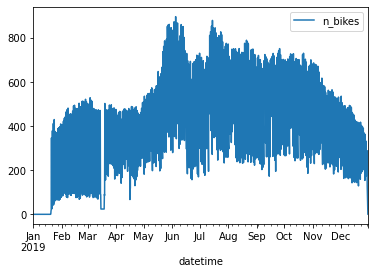

In [20]:
ar.groupby('datetime').sum().plot()
plt.show()

In [21]:
availability.reset_index().to_pickle(AVAILABILITY_PATH)